In [42]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchmetrics import CharErrorRate

import os
import gc
from tqdm import tqdm

import cv2

### Проанализируем номера машин

In [2]:
labels = list(
    map(lambda x: x.split('-')[1].split('.')[0], 
    os.listdir('/kaggle/input/ocr-dataset/CCPD2019-dl1/train/'))
)

In [3]:
min([len(cur) for cur in labels]), max([len(cur) for cur in labels])

(7, 7)

Видно, что длина каждого номера в train части - 7 символов. Подготовим словарь символов

In [4]:
all_symbols = set()
for label in labels:
    all_symbols = all_symbols.union(set(label))

In [5]:
sym_to_id = {
    label : idx + 2 for idx, label in enumerate(all_symbols)
}

In [6]:
sym_to_id['<BOS>'] = 0
sym_to_id['<EOS>'] = 1

### Создадим датасет

In [7]:
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path : str, 
                 sym_to_id : dict,
                 prepare_transforms=None, 
                 augmentations=None) -> None:
        """
            dir_path - path to folder with images
            prepare_transforms - torchvision transforms applying before using image
            augmentations - torchvision transforms for augmentation
        """
        
        self.dir_path = dir_path
        
        if self.dir_path[-1] != '/':
            self.dir_path += '/'
        
        self.img_path = os.listdir(dir_path)
        self.prepare_transforms = prepare_transforms
        self.augmentations = augmentations
        
        self.sym_to_id = sym_to_id
        
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
                
        image = self.prepare_transforms(
            cv2.imread(self.dir_path + self.img_path[idx])
        )
        
        label = self.img_path[idx].split('-')[1].split('.')[0]
        
        label_tensor = torch.LongTensor([0] + [self.sym_to_id[cur] for cur in label] + [1])
        
        if self.augmentations is not None:
            image = self.augmentations(image)
        
        return image, label_tensor

Зададим трансформации для изображений: готовящие к обработке сетью и аугментации

In [8]:
prepare_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((80, 200), antialias=True),
    torchvision.transforms.Grayscale()
])

augmentations = torchvision.transforms.Compose([
    torchvision.transforms.RandomSolarize(threshold=0.5, p=0.5),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=10., p=0.5),
    torchvision.transforms.RandomAutocontrast(p=0.5)
])

Создадим объекты датасетов и даталоадеров

In [9]:
train_dataset = OCRDataset(dir_path="/kaggle/input/ocr-dataset/CCPD2019-dl1/train",
                           prepare_transforms=prepare_transforms,
                           augmentations=augmentations,
                           sym_to_id=sym_to_id
)
test_dataset = OCRDataset(dir_path="/kaggle/input/ocr-dataset/CCPD2019-dl1/test",
                           prepare_transforms=prepare_transforms,
                           augmentations=None,
                           sym_to_id=sym_to_id
)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

### Создадим модель

Она будет состоять из двух блоков - светрочной части (feature extractor) и рекуррентной. 
* Сверточная часть будет состоять из последовательного применения базовых блоков: Conv2d->BatchNorm2d->ReLU->MaxPool2d.
* Рекуррентная - из двух слоев Bidir-LSTM, между которыми будет полносвязный слой.

In [12]:
class OCRModel(nn.Module):
    def __init__(self, lstm_layers, dict_size, emb_dim):
        super().__init__()
        
        self.conv1 = self._conv_block(1, 8)
        self.dropout1 = nn.Dropout(0.1)
        self.conv2 = self._conv_block(8, 4)
        self.dropout2 = nn.Dropout(0.1)
        self.conv3 = self._conv_block(4, 1)
        self.dropout3 = nn.Dropout(0.1)
        
        self.hidden_dim = 250
        
        self.prefix_embedding = nn.Embedding(dict_size, emb_dim)
        self.lstm1 = nn.LSTM(emb_dim, 
                             self.hidden_dim, 
                             num_layers=lstm_layers, 
                             bidirectional=True,
                             dropout=0.1,
                             batch_first=True)
        self.fc1 = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.lstm2 = nn.LSTM(self.hidden_dim, 
                             self.hidden_dim, 
                             num_layers=lstm_layers, 
                             bidirectional=True,
                             dropout=0.1,
                             batch_first=True)
        self.fc2 = nn.Linear(self.hidden_dim * 2, dict_size)
        
    def _conv_block(self, in_channels, out_channels, kernel_size=3, padding=1) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    
    def forward(self, img, prefix):
        X = self.dropout1(self.conv1(img))
        X = self.dropout2(self.conv2(X))
        X = self.dropout3(self.conv3(X))
                
        img_emb = X.reshape(1, X.shape[0], self.hidden_dim).repeat_interleave(2 * self.lstm1.num_layers, dim=0)
        prefix_emb = self.prefix_embedding(prefix)
        out, _ = self.lstm1(prefix_emb, (img_emb, img_emb))
        out = self.fc1(out)
        out, _ = self.lstm2(out, (img_emb, img_emb))
        return self.fc2(out).transpose(1, 2)

Поскольку длина номера фиксирована, выберем в качестве критерия CrossEntropyLoss

In [13]:
model = OCRModel(lstm_layers=3, dict_size=len(all_symbols) + 2, emb_dim=64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [43]:
device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

In [15]:
model = model.to(device)

Обучим модель. На каждом шаге будем учить ее предсказывать следующий токен на основании истиных предыдущих. Будем использовать Teacher Forcing на каждом шаге, чтобы избежать накопления ошибки при тренировке. При инференсе и подсчете метрик предсказывать будем на каждом шаге на основании предсказаний модели на предыдущих шагах.

In [44]:
train_loss = []
val_loss = []

num_epochs = 10

for epoch in range(num_epochs):
    cur_train_loss = []
    cur_val_loss = []
    
    model.train(True)
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        loss = 0
        for i in range(1, 9):
            pred = model(X_batch, y_batch[:, :i])
            target = torch.zeros(y_batch.shape[0], i, dtype=torch.int64).to(device)
            target[:, 0:i] = y_batch[:, 1:i+1]
            loss += criterion(torch.unsqueeze(pred[:, :, -1], -1), y_batch[:, i:i+1])

        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        cur_train_loss.append(loss.item())
        
    model.train(False)
    for X_batch, y_batch in tqdm(test_loader):
        with torch.no_grad():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            loss = 0
            for i in range(1, 9):
                pred = model(X_batch, y_batch[:, :i])
                target = torch.zeros(y_batch.shape[0], i, dtype=torch.int64).to(device)
                target[:, 0:i] = y_batch[:, 1:i+1]
                loss += criterion(torch.unsqueeze(pred[:, :, -1], -1), y_batch[:, i:i+1])

            cur_val_loss.append(loss.item())
        
    train_loss.append(np.mean(cur_train_loss))
    val_loss.append(np.mean(cur_val_loss))
    
    if epoch % 1 == 0:
        print(f"Cur train loss: {train_loss[-1]}; cur_val_loss: {val_loss[-1]}")

In [18]:
id_to_sym = {
    sym_to_id[sym] : sym for sym in sym_to_id
}

Определим функцию, предсказывающую токены, из которых состоит номер, а также функцию переводящую список токенов в строку

In [19]:
def ocr(image : torch.tensor) -> str:
    """
        image - preprocessed image
    """
    idxs = [0]
    
    if len(image.shape) == 3:
        image = torch.unsqueeze(image, 0)
    
    for _ in range(8):
        next_idx = torch.argmax(
            model(image.to(device), 
                  torch.LongTensor([idxs]).to(device))[0, :, -1]
        ).item()
        idxs.append(next_idx)
        
    return idxs

def decode(idxs : torch.tensor) -> str:
    return "".join([id_to_sym[cur] for cur in idxs[1:-1]])

Подсчитаем метрики на тестовой выборке. На тренировочной считать не резонно, поскольку лосс на тренировочной выборке был больше на последней эпохе обучения, чем на тестовой. До этого лосс на тренировочной выборке был стабильно чуть выше лосса на тестовой, оба они планомерно уменьшались. Это позволяет судить о том, что модель не переобучилась.

### Подсчет метрик

In [67]:
preds = []
true_labels = []

test_accuracy_score = 0

for X_cur, y_cur in tqdm(test_dataset):
    pred = ocr(X_cur)
    preds.append(pred)
    true_labels.append(y_cur.numpy().tolist())
    
    test_accuracy_score += pred == y_cur.numpy().tolist()
test_accuracy_score /= len(test_dataset)

In [46]:
print(f"Accuracy on test dataset: {test_accuracy_score}")

Accuracy on test dataset: 0.7808780878087809


In [47]:
print(f"Character Error Rate(CER) on test dataset: {CharErrorRate()(preds, true_labels).item()}")

Character Error Rate(CER) on test dataset: 0.033292219042778015


Достаточно большая accuracy, достаточно маленькая CER.

### Анализ ошибок

In [49]:
errors = dict() # Dict of tuples: key - (true token, predicted token), value - number of errors
for i in range(len(test_dataset)):
    pred = decode(preds[i])
    true_label = decode(true_labels[i])
    for i in range(7):
        if pred[i] != true_label[i]:
            if (true_label[i], pred[i]) in errors:
                errors[(true_label[i], pred[i])] += 1
            else:
                errors[(true_label[i], pred[i])] = 1

Посмотрим на распределение числа ошибок(количество пар неправильно идентифицированных символов)

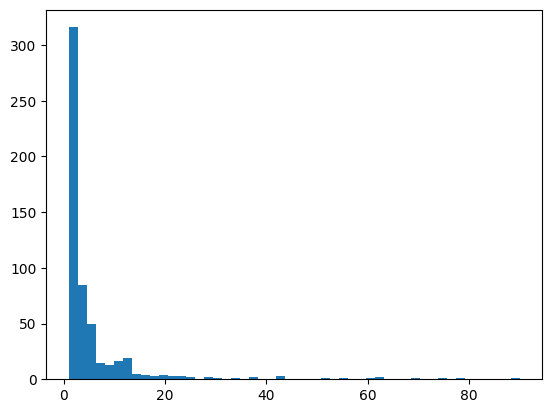

In [55]:
plt.hist(errors.values(), bins=50)
plt.show()

Откинем те, на которых ошиблись до 10 раз (вероятнее ошибка случайная)

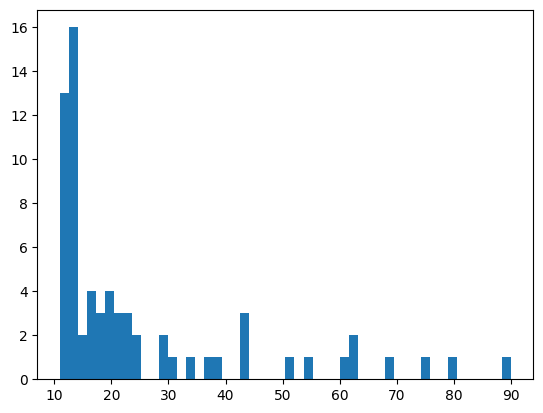

In [60]:
plt.hist([cur for cur in errors.values() if cur > 10], bins=50)
plt.show()

Посмотрим на список пар символов, на которых ошибка присходила наиболее часто

In [66]:
sorted([
    (errors[key], key) for key in errors
], reverse=True)[:20]

[(90, ('Q', '0')),
 (79, ('P', 'R')),
 (75, ('D', '0')),
 (69, ('S', '5')),
 (63, ('苏', '皖')),
 (63, ('R', 'P')),
 (61, ('W', 'M')),
 (55, ('G', 'C')),
 (51, ('5', 'S')),
 (43, ('M', 'W')),
 (43, ('L', 'E')),
 (43, ('C', 'G')),
 (38, ('L', 'A')),
 (37, ('3', '5')),
 (34, ('H', 'W')),
 (31, ('N', 'M')),
 (29, ('8', '0')),
 (29, ('1', 'T')),
 (25, ('F', 'E')),
 (25, ('0', '8'))]

Посмотрев на пары символов, на которых модель чаще всего ошибались, можно заметить, что ошибки совершались наиболее часто на визуально похожих символах (Q и O, D и 0, C и G). Это может значить, что часть, отвечающая за feature extraction недостаточно хорошо справляется со своей задачей. В качестве оптимизации решения можно предложить усложнить сверточную часть. Например добавить несколько сверточных блоков, residual connection.